<a href="https://colab.research.google.com/github/EventHopper/ReviewScraping/blob/master/Eventbrite_App_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Eventbrite Competitive Review**


---


### **Application**
**Eventbrite**

Details:

Size: 15MB,
Installs: 10M+,
Requires Android 5+

---



### **Review Rationale**

*We want to review feedback for this app on the Google Play Store and AppStore. Note that both negative and positive are good, however the negative reviews can reveal critical features that are missing or significant bugs (if they appear frequently).*
<br>

### **Packages Used**

**Google Play Store Related Packages:**

 - [google-play-scraper](https://github.com/JoMingyu/google-play-scraper)

**AppStore Related Packages:**

- TBA (to be added)

# Project Init

In [ ]:
!pip install -qq google-play-scraper

     |████████████████████████████████| 51kB 1.5MB/s 


In [ ]:
!pip install -qq -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

In [ ]:
!pip install pandasql
!pip install chart-studio
!pip install sqlalchemy
!pip install sqlite3
!pip install scikit-plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import json
import time
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandasql import sqldf

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Data Wrangling

## Google Play Store Scraping

Step Summary:

- Scrape Google Play app information
- Scrape user reviews for Google Play apps
- Save the dataset to CSV files

Package name of app: com.facebook.Socal
Obtained using ADB shell command


```
$ adb shell "pm list packages -f facebook"
```

In [ ]:
app_packages = [
  'com.eventbrite.attendee'
]

Utilized package name in for loop (note multiple package names could have been added to app_packages for same result)

In [ ]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='en', country='us')
  del info['comments']
  app_infos.append(info)

100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


We got the info for the app. Let's write a helper function that prints JSON objects a bit better:

In [ ]:
def print_json(json_object):
  json_str = json.dumps(
    json_object, 
    indent=2, 
    sort_keys=True, 
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Here is a sample app information from the list:

In [ ]:
print_json(app_infos[0])

This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5). Let's ignore all of that and have a look at their beautiful icons:

In [ ]:
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title']))
  ax.axis('off')

<Figure size 1008x360 with 0 Axes>

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('app_details'+timestr+'.csv', index=None, header=True)

### Scraping App Reviews

In an ideal world, we would get all the reviews. But there are lots of them and we're scraping the data. That wouldn't be very polite. What should we do?

We want:

- Balanced dataset - roughly the same number of reviews for each score (1-5)
- A representative sample of the reviews for each app

We can satisfy the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness, which are the reviews that Google Play thinks are most important. Just in case, we'll get a subset from the newest, too:

In [ ]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='en',
        country='us',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs)

100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


In [ ]:
print_json(app_reviews[:5])

In [ ]:
len(app_reviews)

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('EventbriteReviews-'+timestr+'.csv', index=None, header=True)

## AppStore Scraping

In [ ]:
!pip install app_store

In [ ]:
import app_store.reviews

In [ ]:
d = []
i = 1;
try:
  while(i < 11):
    reviews = app_store.reviews.fetch_reviews(app_id=487922291, page_num=i)
    for review in reviews:
      d.append((review.title(), review.rating(), review.author_name(), review.version(), review.content()))
    i+=1
except:
  print("Page number not found ", i)

ios_reviews_df = pd.DataFrame(d, columns=('Review_Title', 'Rating', 'Author_Name', 'Review_Version', 'Content'))

In [ ]:
# ios_reviews_df.to_csv('eventbrite_reviews_ios.csv', sep='\t', encoding='utf-8')
ios_reviews_df.head(5)

In [ ]:
reviews_android = app_reviews_df[['content', 'score', 'at']].copy()
reviews_ios = ios_reviews_df[['Content', 'Rating']].copy()
reviews_android.rename(columns={'score': 'rating', 'at': 'date'}, inplace=True)

In [ ]:
reviews_android.to_csv('eventbrite_reviews_android_clean.csv', sep='\t', encoding='utf-8')
reviews_ios.to_csv('eventbrite_reviews_ios_clean.csv', sep='\t', encoding='utf-8')

# EDA

Next, we're going to use the reviews for sentiment analysis with BERT. But first, we'll have to do some text preprocessing!

In [ ]:
android_clean_url = 'https://raw.githubusercontent.com/EventHopper/Research/master/Raw%20Data/Reviews/eventbrite/eventbrite_reviews_android_clean.csv?token=ALBUOYYC2DCSZSWUAZ4EH4S66JYSW'
android_raw_url = 'https://raw.githubusercontent.com/EventHopper/Research/master/Raw%20Data/Reviews/eventbrite/eventbrite_reviews_android_raw.csv?token=ALBUOY4VACZ6DJORZJ7CQA266JYZE'
ios_clean_url = 'https://raw.githubusercontent.com/EventHopper/Research/master/Raw%20Data/Reviews/eventbrite/eventbrite_reviews_ios_clean.csv?token=ALBUOYZ5BQLEQAVIPMCV5O266JZZ6'
ios_raw_url = 'https://raw.githubusercontent.com/EventHopper/Research/master/Raw%20Data/Reviews/eventbrite/eventbrite_reviews_ios_raw.csv?token=ALBUOY2XL6QSKOQZITMEH2K66JZ3A'

In [ ]:
reviews_android_raw = pd.read_csv(android_raw_url)
reviews_android_clean = pd.read_csv(android_clean_url, sep='\t', encoding='utf-8')
reviews_ios_raw = pd.read_csv(ios_raw_url, sep='\t', encoding='utf-8')
reviews_ios_clean = pd.read_csv(ios_clean_url, sep='\t', encoding='utf-8')

In [ ]:
reviews_android_clean['date'] = reviews_android_clean['date'].apply(lambda x : pd.to_datetime(x))
reviews_android_clean['date'] = reviews_android_clean['date'].dt.strftime('%Y-%m')

In [ ]:
opinions_df = lambda q: sqldf(q, globals())
query = """
SELECT
    AVG(p.rating) as average_score, p.date as date
FROM
    reviews_android_clean p
GROUP BY
    p.Date
ORDER BY
    p.Date ASC
"""
df_temp = opinions_df(query)
# df_temp.head()
android_grouped_by_score_df = df_temp
android_grouped_by_score_df.head()

,average_score,date
0,2.400000,2018-09
1,2.636364,2018-10
2,2.733333,2018-11
3,2.444444,2018-12
4,2.800000,2019-01


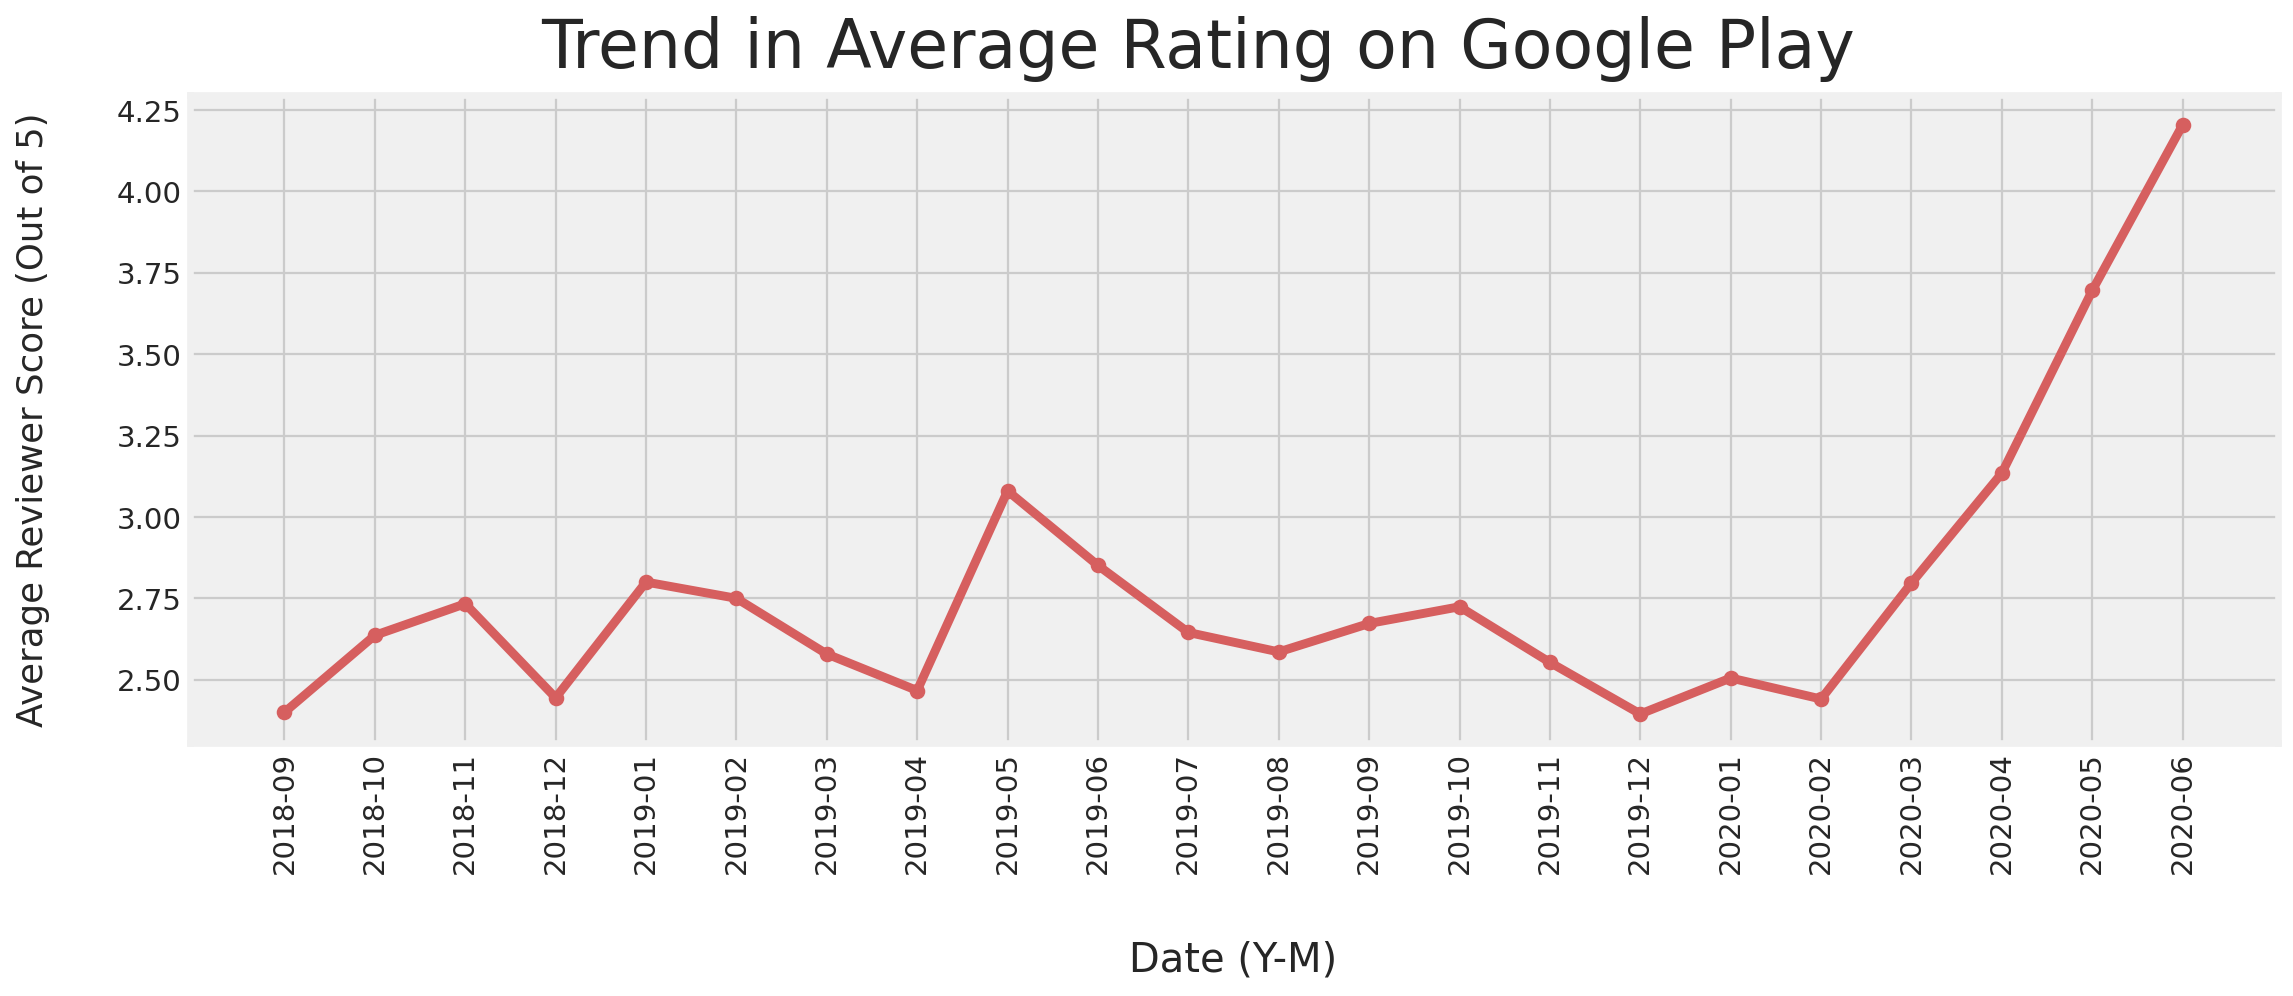

In [ ]:
labelpad = 30
    
with plt.style.context('fivethirtyeight'):
    fig = figure(num=None, figsize=(15,5), dpi=80, facecolor='white', edgecolor='w')
    fig.suptitle('Trend in Average Rating on Google Play', fontsize=30)
    plt.xlabel('Date (Y-M)', fontsize=18, labelpad=labelpad)
    plt.ylabel('Average Reviewer Score (Out of 5)', fontsize=16, labelpad=labelpad)
    plt.plot(android_grouped_by_score_df.date, android_grouped_by_score_df.average_score, 'r-o')
    plt.xticks(rotation='vertical',ticks = None, labels=None)
plt.show()

In [ ]:
from textblob import TextBlob

**Polarity Metric** - from -1 to 1 a metric of how positive or negative a review is 

**Subjectivity Metric** - measured between 0 and 1 based on factual information vs generic opinion

[See Here for Learning about TextBlob](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/#:~:text=The%20sentiment%20function%20of%20textblob,properties%2C%20polarity%2C%20and%20subjectivity.&text=Subjective%20sentences%20generally%20refer%20to,of%20%5B0%2C1%5D.)

[TextBlob uses a Naive Bayes algorithm as a part of Stanford's NLTK and was trained on movie reviews to determine textual sentiment](https://stackoverflow.com/questions/34518570/how-are-sentiment-analysis-computed-in-blob)

In [ ]:
android_reviews_df = reviews_android_clean
android_reviews_df['word_count'] = android_reviews_df['content'].apply(lambda x: len(x.split()))
android_reviews_df.head(10)

,Unnamed: 0,content,rating,date,word_count
0,0,Bought two tix from a Facebook post that had t...,1,2020-05,73
1,1,Recent version doesn't allow to get tickets fr...,1,2020-06,30
2,2,The worst experience as an organizer. Since th...,1,2020-05,45
3,3,This App is worst then the site itself. The si...,1,2020-04,94
4,4,There are information about entering into an e...,1,2020-04,78
5,5,The screen overrides your settings & becomes u...,1,2020-06,17
6,6,Does not work on Chromebooks laptop. You can't...,1,2020-03,26
7,7,"It wouldn't let me log in, uninstall and insta...",1,2020-04,23
8,8,"It is very slow on my android phone, and the r...",1,2020-04,19
9,9,Still waiting on refunds for tickets that have...,1,2020-05,30


In [ ]:
ios_reviews_df = reviews_ios_raw
ios_reviews_df['word_count'] = ios_reviews_df['Content'].apply(lambda x: len(x.split()))
ios_reviews_df.head()

,Unnamed: 0,Review_Title,Rating,Author_Name,Review_Version,Content,word_count
0,0,Lazy,1,fgdgfdfdfd,8.0.8,Look people use your app. We should be able to...,38
1,1,iPhone Calendar won’t integrate,1,Garland8,8.0.8,I cannot add events to my iPhone calendar. Bot...,22
2,2,Not iPhone friendly,1,Carlotta429,8.0.8,It would be way easier if I could put these in...,38
3,3,The won’t issue refunds for cancelled shows!,1,jdthompson,8.0.8,Be careful! They will take your money and the...,20
4,4,Clubhouse Reunion Tickets,1,WashRedSkins,8.0.8,I am very unpleased because I have requested a...,26


# Summary

TBA

# References


- [Brilliant tutorial for Google Play Store Scraping](https://www.curiousily.com/posts/create-dataset-for-sentiment-analysis-by-scraping-google-play-app-reviews-using-python/)